# Born approximation

$p = F(c), \\
p_1 = F(c+\delta c) \approx F(c) + DF[c]\delta c = p + \delta p$

In [1]:
using PyPlot, LinearAlgebra, ImageFiltering, JLD2, MATLAB, MAT

include("code/acoustic_solver.jl")
include("code/acoustic_solver_parallel.jl")
include("code/adjoint_method.jl")
include("code/adjoint_method_new.jl")
include("code/TV_projection.jl")
include("code/TV_function.jl")
include("code/optimization.jl");

In [2]:
# load data
file = matopen("marmousi_data/marmousi_vp10.mat")
vp10 = read(file, "marmousi_vp10") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

Nx = 101
Ny = 101
h = 10*1e-3

c_true = vp10[31:31+Nx-1,780:780+Ny-1]

# gaussian filter to generate the initial model
c = imfilter(c_true, Kernel.gaussian(5));
c = (c .- minimum(c)) ./ (maximum(c)-minimum(c)) * (maximum(c_true)-minimum(c_true)) .+ minimum(c_true);
c[1:16, :] .= 1.5
rho = ones(Nx,Ny);

delta_c = c_true - c;

CFL: 0.47383324305216473

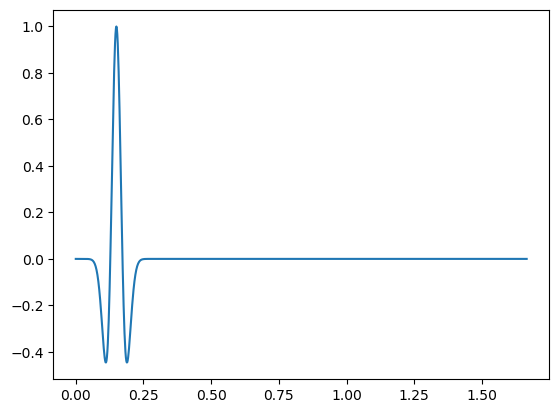

In [3]:
# setup coef
Nt = 1000
Fs = 600
dt = 1 / Fs
t = range(0, step=dt, length=Nt)
println("CFL: ", maximum(c_true) * dt / h);

# source
source = source_ricker(10,0.15,t)
source_num = 6
source_position = zeros(Int,source_num,2)
for i = 1:source_num
    source_position[i,:] = [5 1+20(i-1)]
end
source = repeat(source, 1, 1);

# receiver
receiver_num = 101
receiver_position = zeros(Int,receiver_num,2)
for i = 1:receiver_num
    receiver_position[i,:] = [1, (i-1)*1+1]
end

# PML
pml_len = 30
pml_coef = 50;

plot(t,source);

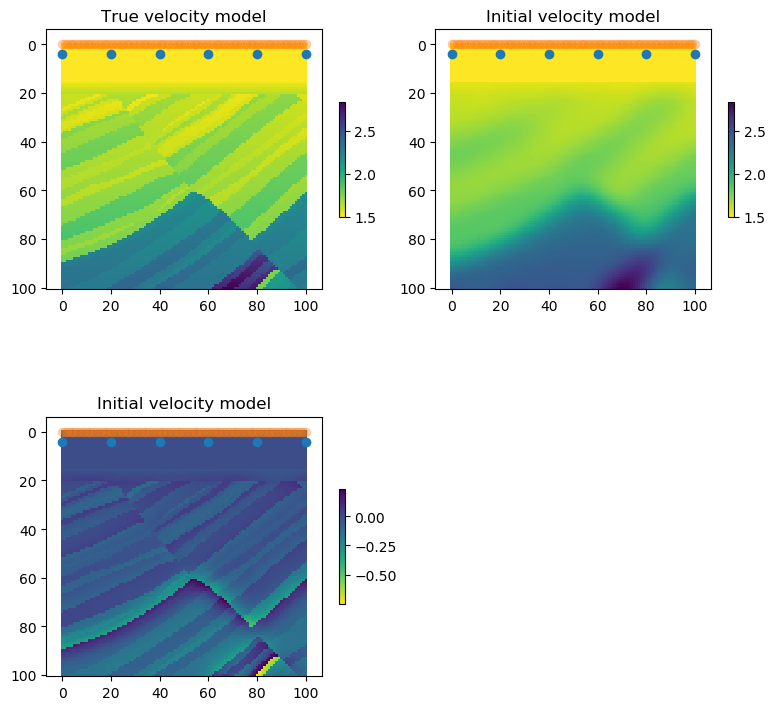

In [4]:
# plot model
figure(figsize=(8,8))

subplot(221)
imshow(c_true, cmap="viridis_r"); title("True velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

subplot(222)
imshow(c, cmap="viridis_r"); title("Initial velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

subplot(223)
imshow(delta_c, cmap="viridis_r"); title("Initial velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

tight_layout()

In [5]:
@time p, data_p = multi_solver(c, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=30, pml_coef=50);

@time p1, data_p1 = multi_solver(c+delta_c, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=30, pml_coef=50);


  7.924828 seconds (14.69 M allocations: 1.160 GiB, 5.49% gc time)
  4.061547 seconds (713.99 k allocations: 526.449 MiB, 2.22% gc time)


In [6]:
@time data_delta_p = single_scattering(p, delta_c, c, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=30, pml_coef=50);





 27.831602 seconds (7.61 M allocations: 4.002 GiB, 3.53% gc time)


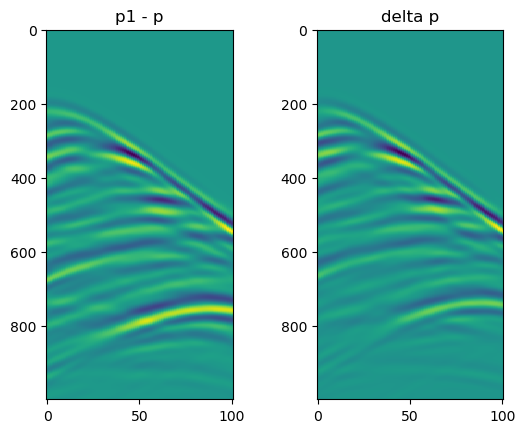

PyObject Text(0.5, 1, 'delta p')

In [7]:
source_ind = 1
subplot(121)
imshow(data_p1[:,:,source_ind] - data_p[:,:,source_ind], aspect=0.2); title("p1 - p")
subplot(122)
imshow(data_delta_p[:,:,source_ind], aspect=0.2); title("delta p")

In [8]:
@time pp = normal_op(p, c, c, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=30, pml_coef=50);





 31.155775 seconds (8.39 M allocations: 5.016 GiB, 4.30% gc time)


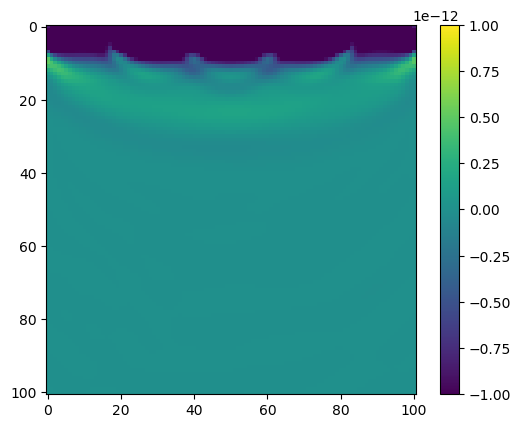

In [9]:
imshow(reshape(pp,Nx,Ny)); colorbar()
clim(-1e-12, 1e-12)

## Test normal operator
The problem is:
$$Q DF[u] \delta u = \delta p$$
Then we solve the normal equation:
$$(DF[u]^* Q^*) (QDF[u]) \delta u = DF[u]^* Q^* \delta p$$
Another form:
$$\left( (DF[u]^* Q^*) (QDF[u])  + \lambda I \right)\delta u = DF[u]^* Q^* \delta p$$

In [10]:
adj_source = data_delta_p


@time grad = adjoint_op(p, adj_source, c, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=30, pml_coef=50);




  5.192025 seconds (3.37 M allocations: 1.114 GiB, 5.36% gc time)


In [11]:
# imshow(reshape(grad, Nx, Ny));

In [12]:
u = copy(c)
y = copy(p)
grad;

delta_u0 = zeros(Nx*Ny,1)
delta_u1 = zeros(Nx*Ny,1)
r0 = -1 * grad
r1 = similar(r0)
p0 = -1 * r0
p1 = similar(p0);

for k = 1:30
    q0 = normal_op(y, p0, c, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=30, pml_coef=50);
    theta1 = sum(r0.*r0)
    theta2 = sum(q0.*p0)
    alpha = theta1 / theta2
    
    delta_u1 = delta_u0 + alpha * p0
    r1 = r0 + alpha * q0
    beta = sum(r1.*r1) / theta1
    p1 = -r1 + beta * p0
    
    # update
    r0 = copy(r1)
    p0 = copy(p1)
    
    println(k)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [15]:
qq = normal_op(y, delta_u1, c, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=30, pml_coef=50);
println("||Df|| = ", norm(grad), ".    ||H[u] delta_u + Df|| = ", norm(qq+grad), ". k = ", 30)

||Df|| = 5.823213991042774e-12.    ||H[u] delta_u + Df|| = 6.2880056047153995e-12. k = 30


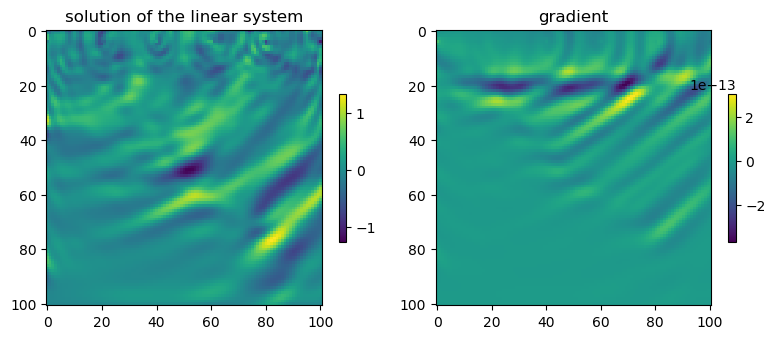

In [14]:
figure(figsize=(8,4))

subplot(121)
imshow(reshape(delta_u1, Nx, Ny)); colorbar(shrink=0.4); title("solution of the linear system")

subplot(122)
imshow(reshape(-grad, Nx, Ny)); colorbar(shrink=0.4); title("gradient")

tight_layout()